We will be using Neural Style Transform Algorithm and this is not an original algorithm and is developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge. We are simply implementing the paper here.
This algorithm is not perfect and have its limitations and there have been some better research and better algorithms, but due to computating units constraints we are sticking with this algorithm for this assignment

The aglorithm works by taking in an input image and a style image and tries to reconstruct the input image as per the "style" of style image. This is done by minimizing the distance of our input image from the style image Ds and from the original image Dc.

The implementation is done using Pytorch

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import vgg19, VGG19_Weights
import copy
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [93]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'lbfgs' #'adam'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 1000
SHOW_ITER = 100

# Image Files
INIT_IMAGE = 'random'   # we will initialize from noise and create an image from it
PIXEL_CLIP = 'True'                # for better images
img_path = "/content/drive/MyDrive/Placements/"

CONTENT_PATH = img_path+"Virat Kohli_3.jpg"
STYLE_PATH = img_path+"picasso.jpg"

model_path = "/content/drive/MyDrive/Placements/vgg19-d01eb7cb.pth"
pool = "max"



In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [80]:
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

def show(img):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convert from BGR to RGB
    img = np.array(img/255).clip(0,1)

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

In [84]:
# Preprocessing
def img_to_tensor(img):

    H, W, C = img.shape     # Rescale the image
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])

    temp_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    norm = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])     # here we subtract the means to normalize
    tensor = norm(temp_transform(img)*255)


    tensor = tensor.unsqueeze(dim=0)        # Add the batch_size dimension
    return tensor

def tensor_to_img(tensor):
    temp = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])           # denormalize - thus add back the means

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = temp(tensor)
    img = img.cpu().numpy()

    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

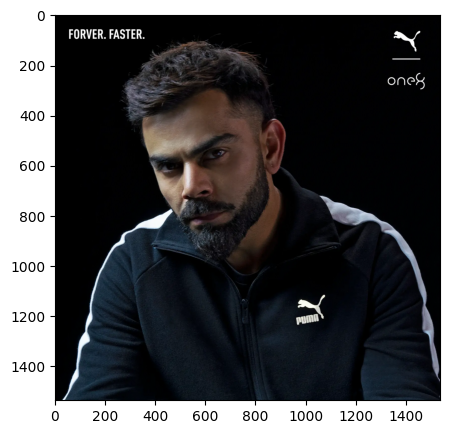

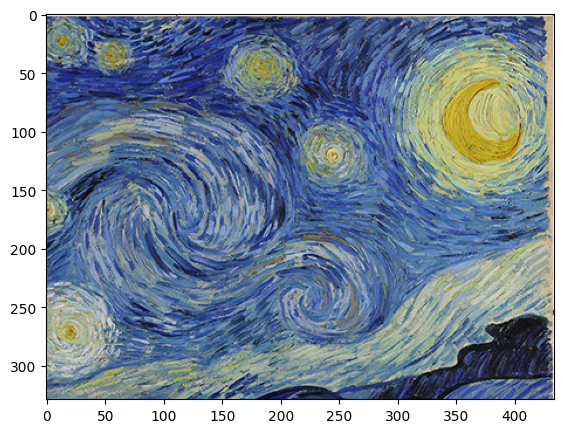

In [82]:
# Load Images
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)

# Show Images
show(content_img)
show(style_img)

In [5]:
# Color transfer
def transfer_color(src, dest):
    src, dest = src.clip(0,255), dest.clip(0,255)

    # Resize src to dest's size
    H,W,_ = src.shape
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) # Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   # Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         # Combine Destination's luminance and Source's IQ/CbCr

    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  # Convert new image from YIQ back to BGR

In [51]:
x = torch.load(model_path,map_location="cuda")

In [83]:
vgg = models.vgg19(pretrained=False)        # Load VGG19 Skeleton
vgg.load_state_dict(x, strict=False)        # Load pretrained weights

# Change Pooling Layer to univerally the same one
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1

    return model

vgg.features = pool_(vgg.features, pool)

# Extract only the 'features' network,
# 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [53]:
# loss functions
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(img, content):
    loss = mse_loss(img, content)
    return loss

def style_loss(img, style):
    c1,c2 = img.shape
    loss = mse_loss(img, style)
    return loss / (c1**2)           # Divide by square of channels

def tv_loss(c):                     # total variational loss - encourages spatial smoothness in generated images
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [54]:
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }

    # Get features - here we want to extract the features of content and style respectively
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)

            # Terminate forward pass
            if (name == '35'):
                break

    return features

In [90]:
def initialize(content_tensor, init_image='random'):           # initializing the image
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()

    return tensor

In [96]:
def style_transfer(iteration=NUM_ITER):
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0}
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)

    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            new_img_feat = get_features(model, new_img)

            # Compute Losses - specific to content and style losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(new_img_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(new_img_feat[j], s_feat[j])

            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(new_img.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)

            # Print Loss and show image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                recons_img = tensor_to_img(new_img.clone().detach())
                show(recons_img)
                plt.show()

            return (total_loss)


        optimizer.step(closure)

    return new_img

In [ ]:
content_tensor = img_to_tensor(content_img).to(device)
style_tensor = img_to_tensor(style_img).to(device)

# initialize our new image with random noise
new_img = initialize(content_tensor, init_image="random")
new_img = new_img.to(device).requires_grad_(True)

if (OPTIMIZER=='lbfgs'):
    optimizer = optim.LBFGS([new_img])
elif (OPTIMIZER=='adam'):
    optimizer = optim.Adam([new_img], lr=ADAM_LR)

# Stylize!
out = style_transfer(iteration=NUM_ITER)

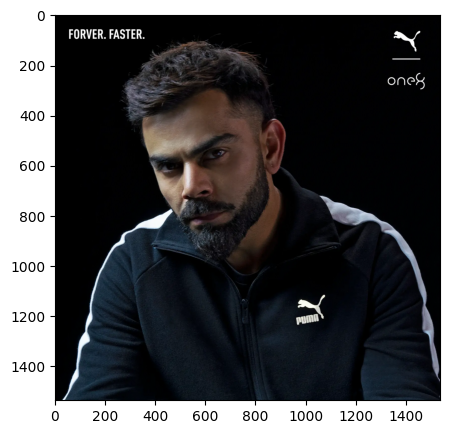

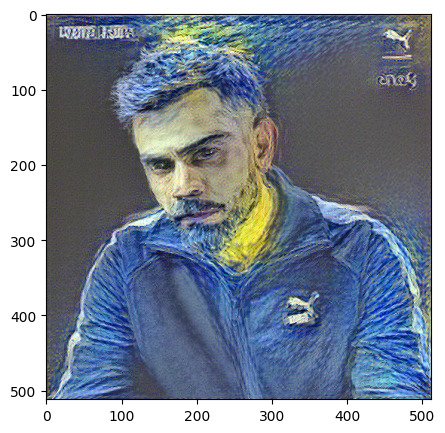

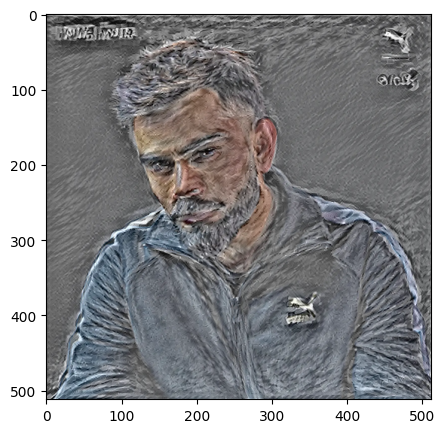

In [100]:
show(content_img) # Original Content
show(tensor_to_img(g.clone().detach())) # Style Transfered

og_clone = tensor_to_img(content_tensor.clone().detach())
new_clone = tensor_to_img(new_img.clone().detach())
color_preserved = transfer_color(og_clone, new_clone) # Style Transfer + Preserve original color
show(color_preserved)

We can see from the above demostration of the code that we are able to create a new image which copies the style from one image and content from some other image by decreasing the 2 losses namely Content Loss and Style Loss.

This algorithm is not the most efficient one as it will working on optimizing 2 losses. There is a better algorithm called Fast Neural Style Transfer which trains a FFN about the paramters of the style rather than copying the style like in the traditional Neural Style Tranfer Methods as we are using here.

This algorithm is good when we don't have a lot of data and simply want to copy the style, but if we have the data and computation power it will be better if we use Fast Neural Style Transfer where we train the FFN about the style then we can simply transform any content image by forwarding that image through that network.
